In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

import random

from subprocess import check_output
from collections import Counter

from keras_tqdm import TQDMNotebookCallback
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten,Activation,Conv2D,MaxPooling2D,Flatten
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback

from scipy import ndimage
import cv2 
import os
import shutil

%matplotlib inline

## read train&test&train.csv


In [54]:
train_org_images = glob("./train_org/*jpg")
test_images = glob("./test/*jpg")
df = pd.read_csv("./train.csv")
SIZE = 64

In [55]:
df["Image"] = df["Image"].map( lambda x : "./train_org/"+x)
ImageToLabelDict = dict( zip( df["Image"], df["Id"]))

In [56]:
ImageToLabelDict

{'./train_org/00022e1a.jpg': 'w_e15442c',
 './train_org/000466c4.jpg': 'w_1287fbc',
 './train_org/00087b01.jpg': 'w_da2efe0',
 './train_org/001296d5.jpg': 'w_19e5482',
 './train_org/0014cfdf.jpg': 'w_f22f3e3',
 './train_org/0025e8c2.jpg': 'w_8b1ca89',
 './train_org/0026a8ab.jpg': 'w_eaad6a8',
 './train_org/0031c258.jpg': 'new_whale',
 './train_org/0035632e.jpg': 'w_3d0bc7a',
 './train_org/0037e7d3.jpg': 'w_50db782',
 './train_org/00389cd7.jpg': 'w_2863d51',
 './train_org/0042dcc4.jpg': 'w_6dc7db6',
 './train_org/0042ea34.jpg': 'w_968f2ca',
 './train_org/00467ae9.jpg': 'w_fd1cb9d',
 './train_org/004a97f3.jpg': 'w_60759c2',
 './train_org/004c5fb9.jpg': 'w_ab6bb0a',
 './train_org/005c57e7.jpg': 'w_79b42cd',
 './train_org/006d0aaf.jpg': 'w_c9ba30c',
 './train_org/0078af23.jpg': 'w_e6ec8ee',
 './train_org/007c3603.jpg': 'new_whale',
 './train_org/00863b8c.jpg': 'new_whale',
 './train_org/008809b5.jpg': 'w_7e5cc5e',
 './train_org/008baccf.jpg': 'w_ab6db0f',
 './train_org/0091c92b.jpg': 'w_bc

In [5]:
num_classes=df['Id'].nunique()
print(num_classes)

4251


In [38]:
num=df['Id'].count()
print(num)

9850


In [44]:
#image are imported with a resizing and a black and white conversion
def ImportImage( filename):
    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE))
    return np.array(img)[:,:,0]

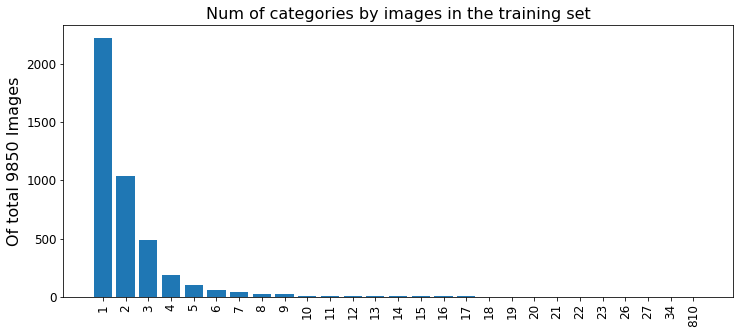

In [6]:
size_buckets = Counter(df['Id'].value_counts())
total=df.shape[0]

plt.figure(figsize=(12, 5))

plt.bar(range(len(size_buckets)), list(size_buckets.values())[::-1], align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys())[::-1],size=12,rotation='90')
plt.yticks(size=12)
plt.ylabel("Of total {} Images".format(total),size=16)
plt.title("Num of categories by images in the training set",size=16)
plt.savefig('NumberOfCategories.png')
plt.show()

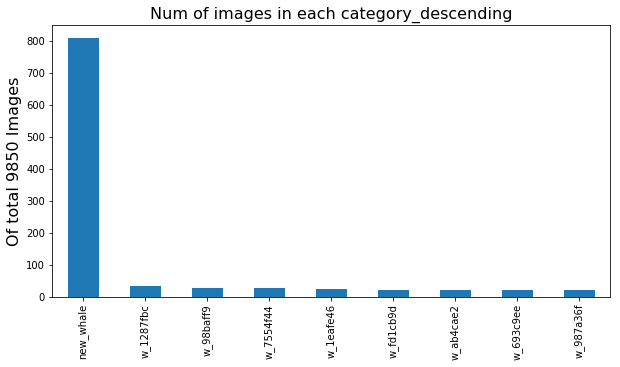

In [9]:
plt.figure(figsize=(10, 5))
plt.ylabel("Of total {} Images".format(total),size=16)
plt.title("Num of images in each category_descending",size=16)
df["Id"].value_counts()[:9].plot(kind='bar')
plt.savefig('NumberOfImages.png')

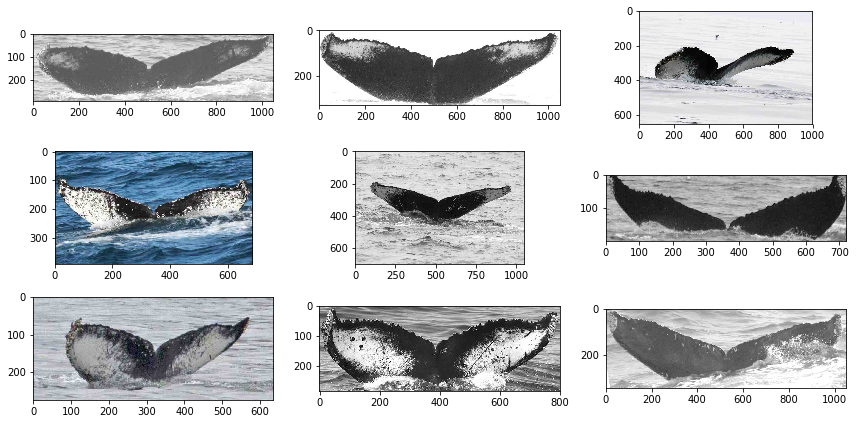

In [10]:

plt.figure(figsize=(12, 6))

for num ,cat_name in enumerate(df["Id"].value_counts()[:9].iteritems()):
    img_name=random.choice(df[df['Id']==cat_name[0]]['Image'].tolist())
    img=np.array(Image.open(os.path.join('./train_org/',img_name)))
    plt.subplot(3,3,num+1)
    plt.imshow(img)
    plt.tight_layout()

In [11]:
df.groupby(['Id'])

In [12]:
sub_categories=[]
for idx,condition in (df["Id"].value_counts()>2).iteritems():
    if condition==True:
        sub_categories.append(idx)

In [23]:
sub_df=df[df['Id'].isin(sub_categories)]
sub_df.shape
#sub_df.head(2)

(5562, 2)

In [22]:
#sub_df['Id'].value_counts()<4
c=0
for idx,condition in (df["Id"].value_counts()<4).iteritems():
    if condition==True:
        c=c+1
        
print(c)        

3746


In [25]:
num_sub_classes=sub_df['Id'].nunique()
print(num_sub_classes)

997


In [26]:
le = LabelEncoder()
##transfer original labels to sorted number
sub_df["Lables"]=le.fit_transform(sub_df["Id"])
##change pandas series to variable
lables=sub_df.Lables
## onehot encoding for neural nets
y_train=to_categorical(sub_df["Lables"], num_classes=num_sub_classes)

/Users/parisarezaie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [243]:
## Copy all files from train_org to new directory:train
#if not os.path.exists('./train_sub/'):
#    shutil.copytree('./train_org/','./train_sub/')

In [28]:
path_org_imgs = "./train_org/"
sub_imgs="./train_sub/"                 
def categorize_image_class(org_imgs_dir,sub_dir,dataframe):

    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir)
        
    for c in set(dataframe.Lables): 
        os.makedirs('./train_sub/{0}/'.format(c))
    
    file_names = dataframe['Image'].tolist()
    
    for f in file_names: 
        shutil.copy(os.path.join(org_imgs_dir,f), 
                        os.path.join(sub_dir, str(dataframe[dataframe["Image"] == f]['Lables'].iloc[0])))

categorize_image_class(path_org_imgs,sub_imgs,sub_df)

In [29]:
def organize_datasets_test(path_to_data,dataframe, ratio=0.35):
    
    '''
    A function that takes the path to all images (with subdirectories for each class)
    and construct a train/dev/test directories with random sampling of all classes for training
    the convlutional neural network.
    The defualt split ratio is: train (90%)/dev(10%)/test(10%)
    '''
    
    for c in set(dataframe.Lables):
        if not os.path.exists('./data/train/{0}/'.format(c)):
            os.makedirs('./data/train/{0}/'.format(c))
            
        if not os.path.exists('./data/dev/{0}/'.format(c)):
            os.makedirs('./data/dev/{0}/'.format(c))
        
    for i in set(dataframe.Lables):  
        files=os.listdir(os.path.join(path_to_data, str(i)))
        random.shuffle(files)
        
        n = int(len(files) * ratio)   
        
        dev, train = files[:n], files[n:]
        
        for filename in dev:
            shutil.copy2(os.path.join(path_to_data,str(i),filename), os.path.join('.', 'data', 'dev', str(i)))
        for filename in train:
            shutil.copy2(os.path.join(path_to_data,str(i),filename),os.path.join('.', 'data', 'train', str(i)))
          
    print('Train, Dev. Directories Constructed!')
    
organize_datasets_test(sub_imgs,sub_df, ratio=0.35)

Train, Dev. Directories Constructed!


In [73]:
#test=ndimage.imread("./train/1/78ea29eb.jpg",mode="RGB")
#test2=cv2.imread("./train/1/78ea29eb.jpg")

In [262]:
#w_size=[]
#L_size=[]
#def SizeImage( filename):
 #   img = ndimage.imread(filename,mode="RGB")
 #   w_size.append(img.shape[0])
 #   L_size.append(img.shape[1])
 #   return w_size,L_size
#train_sizes =[SizeImage( img) for img in train_images]

In [263]:
#min(w_size),max(w_size),min(L_size),max(L_size)

In [264]:
#size1=64
#size2=64

#X_data=[]

#for myFile in train_images:
#    image = cv2.imread(myFile)
    #image=image.resize((size1,size2,3))
  #  X_data.append(image)
    
#X_data_array=np.array(X_data)

#print('X_data shape:', X_data_array.shape)

In [30]:
batch_size=32

datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = datagen.flow_from_directory("./data/train/",
                                              target_size=(64, 64),
                                              batch_size=batch_size,
                                              color_mode="grayscale",
                                              class_mode='categorical')


validation_generator = val_datagen.flow_from_directory('./data/dev/',
                                                target_size=(64, 64),
                                                batch_size=batch_size,
                                                color_mode="grayscale",
                                                class_mode='categorical')

Found 5052 images belonging to 997 classes.
Found 2864 images belonging to 997 classes.


In [31]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',input_shape=(64, 64, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(num_sub_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()-


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)        18496     
__________

In [32]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

## Callback for early stopping the training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=20,
                              verbose=0, mode='auto')

In [34]:
epochs = 60

fitted_model = model.fit_generator(
        train_generator,  
        steps_per_epoch= int(train_generator.n/train_generator.batch_size),
        validation_data=validation_generator,
        epochs=epochs,
        validation_steps= int(validation_generator.n/validation_generator.batch_size),
        callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), early_stopping, history],verbose=0)

HBox(children=(IntProgress(value=0, description='Training', max=60), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 51', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=157), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=157), HTML(value='')))

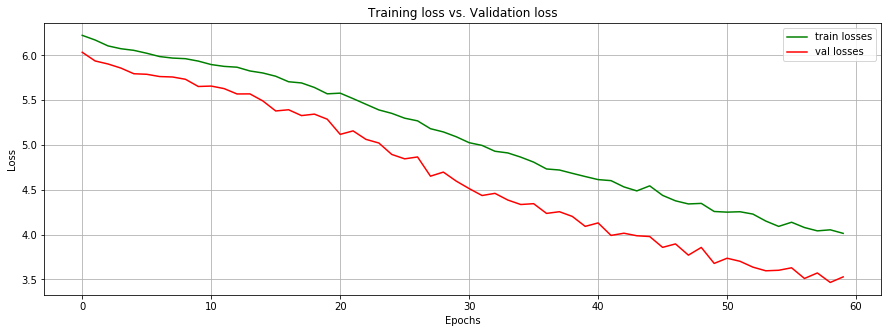

In [39]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('TrainingVsValidationLoss.png')

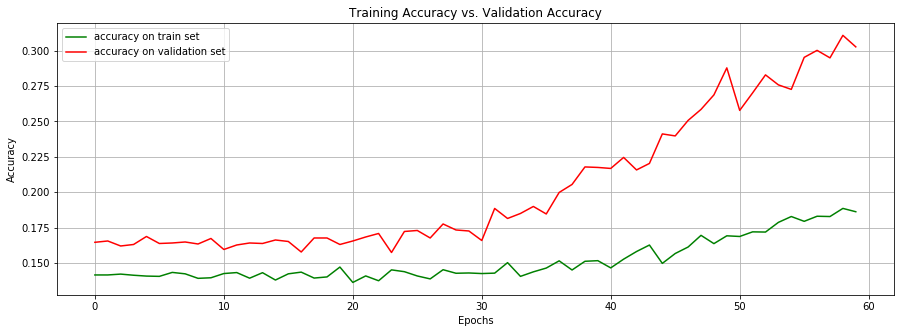

In [40]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation set")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('TrainingVsValidationAccuracy.png')

In [42]:
test_images

['./test/cb2aa96f.jpg',
 './test/703b6a1d.jpg',
 './test/ce79ac9d.jpg',
 './test/7cd1936f.jpg',
 './test/c1da857c.jpg',
 './test/1343b5ca.jpg',
 './test/4378186a.jpg',
 './test/d97bb43b.jpg',
 './test/6c024503.jpg',
 './test/e14189c6.jpg',
 './test/b6188d6c.jpg',
 './test/cf2a74d8.jpg',
 './test/dff4b248.jpg',
 './test/265a33a3.jpg',
 './test/e3c0cfa0.jpg',
 './test/6c0c7e05.jpg',
 './test/f6b89cb9.jpg',
 './test/716ecf4d.jpg',
 './test/f06dd353.jpg',
 './test/f0df5507.jpg',
 './test/f151cf92.jpg',
 './test/91aa97c3.jpg',
 './test/887b2787.jpg',
 './test/5e31631d.jpg',
 './test/1f3d04ca.jpg',
 './test/b208240a.jpg',
 './test/af3d3a07.jpg',
 './test/fe54c170.jpg',
 './test/99a818bd.jpg',
 './test/df00a243.jpg',
 './test/c17812c6.jpg',
 './test/4ca00609.jpg',
 './test/6d6748a1.jpg',
 './test/61764a27.jpg',
 './test/1435a54c.jpg',
 './test/aa7dcf20.jpg',
 './test/d5e4007d.jpg',
 './test/8aa11310.jpg',
 './test/42fd0049.jpg',
 './test/1ff136ec.jpg',
 './test/ffe57505.jpg',
 './test/9bc0a28

In [57]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

y = list(map(ImageToLabelDict.get, train_org_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)

In [59]:
from os.path import split

with open("sample_submission.csv","w") as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        for image in test_images:
            img = ImportImage( image)
            x = img.astype( "float32")
            #applying preprocessing to test images
            x = datagen.standardize( x.reshape(1,SIZE,SIZE))
            
            y = model.predict_proba(x.reshape(1,SIZE,SIZE,1))
            predicted_args = np.argsort(y)[0][::-1][:5]
            predicted_tags = lohe.inverse_labels( predicted_args)
            image = split(image)[-1]
            predicted_tags = " ".join( predicted_tags)
            f.write("%s,%s\n" %(image, predicted_tags))